In [336]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np
import statsmodels.formula.api as sf
import statsmodels.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")
#Importing the necessary packages
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy import stats

In [337]:
covid_df = pd.read_parquet("../../../data/covid_combined_dataset.parquet.gzip")
covid_df.head()

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
0,1001,Autauga County,AL,1,2020-01-22,0,0,55869
1,1001,Autauga County,AL,1,2020-01-23,0,0,55869
2,1001,Autauga County,AL,1,2020-01-24,0,0,55869
3,1001,Autauga County,AL,1,2020-01-25,0,0,55869
4,1001,Autauga County,AL,1,2020-01-26,0,0,55869


In [338]:
# Calculate the number of new cases per day using diff
covid_df["new_cases"] = covid_df["Cases"].diff()
covid_df["new_death"] = covid_df["Death"].diff()
covid_df['new_cases'][covid_df['new_cases'] < 0] = 0
covid_df['new_death'][covid_df['new_death'] < 0] = 0
covid_df = covid_df[covid_df['County Name']!='statewide unallocated']
covid_df = covid_df[covid_df['Date'] != '2020-01-22']
covid_df

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population,new_cases,new_death
1,1001,Autauga County,AL,1,2020-01-23,0,0,55869,0.0,0.0
2,1001,Autauga County,AL,1,2020-01-24,0,0,55869,0.0,0.0
3,1001,Autauga County,AL,1,2020-01-25,0,0,55869,0.0,0.0
4,1001,Autauga County,AL,1,2020-01-26,0,0,55869,0.0,0.0
5,1001,Autauga County,AL,1,2020-01-27,0,0,55869,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2381631,56045,Weston County,WY,56,2022-02-13,1524,17,6927,0.0,0.0
2381632,56045,Weston County,WY,56,2022-02-14,1524,17,6927,0.0,0.0
2381633,56045,Weston County,WY,56,2022-02-15,1528,17,6927,4.0,0.0
2381634,56045,Weston County,WY,56,2022-02-16,1528,17,6927,0.0,0.0


In [339]:
covid_df = covid_df.groupby("Date").sum().reset_index()
covid_df

,Date,countyFIPS,StateFIPS,Cases,Death,population,new_cases,new_death
0,2020-01-23,95465426,95140,734,1,328239523,11.0,0.0
1,2020-01-24,95465426,95140,741,1,328239523,7.0,0.0
2,2020-01-25,95465426,95140,751,1,328239523,10.0,0.0
3,2020-01-26,95465426,95140,759,1,328239523,8.0,0.0
4,2020-01-27,95465426,95140,769,1,328239523,10.0,0.0
...,...,...,...,...,...,...,...,...
752,2022-02-13,95465426,95140,75409177,874847,328239523,40104.0,698.0
753,2022-02-14,95465426,95140,75585682,877542,328239523,179450.0,2721.0
754,2022-02-15,95465426,95140,75665834,879789,328239523,80510.0,2251.0
755,2022-02-16,95465426,95140,75808328,882239,328239523,143835.0,2485.0


In [340]:
def generate_first_occurance_case(df):
    new_case_firstday = df['new_cases'].astype(int).tolist()
    newcase = next((i for i, j in enumerate(new_case_firstday) if j >0 ), None)
    super_df_firstcase = df.loc[newcase:,['Date','new_cases']]
    # Add a new column num_of_days in an order of index, but starting from 1 to assign x-value i.e 
    # number of days from the first day of infection
    mylist = []
    for i in range(1,(len(super_df_firstcase)+1)):
        mylist.append(i)
    super_df_firstcase['num_of_days'] = mylist
    return super_df_firstcase

In [341]:
def generate_first_occurance_death(df):
    new_death_case_firstday = df['new_death'].astype(int).tolist()
    newcase = next((i for i, j in enumerate(new_death_case_firstday) if j >0 ), None)
    super_df_firstdeath = df.loc[newcase:,['Date','new_death']]
    # Add a new column num_of_days in an order of index, but starting from 1 to assign x-value i.e 
    # number of days from the first day of infection
    mylist = []
    for i in range(1,(len(super_df_firstdeath)+1)):
        mylist.append(i)
    super_df_firstdeath['num_of_days'] = mylist
    return super_df_firstdeath

In [342]:
us_firstcase_df = generate_first_occurance_case(covid_df)
us_firstcase_df

,Date,new_cases,num_of_days
0,2020-01-23,11.0,1
1,2020-01-24,7.0,2
2,2020-01-25,10.0,3
3,2020-01-26,8.0,4
4,2020-01-27,10.0,5
...,...,...,...
752,2022-02-13,40104.0,753
753,2022-02-14,179450.0,754
754,2022-02-15,80510.0,755
755,2022-02-16,143835.0,756


In [343]:
us_firstdeath_df = generate_first_occurance_death(covid_df)
us_firstdeath_df

,Date,new_death,num_of_days
15,2020-02-07,1.0,1
16,2020-02-08,0.0,2
17,2020-02-09,0.0,3
18,2020-02-10,0.0,4
19,2020-02-11,0.0,5
...,...,...,...
752,2022-02-13,698.0,738
753,2022-02-14,2721.0,739
754,2022-02-15,2251.0,740
755,2022-02-16,2485.0,741


In [344]:
def generate_model(degree,df,casetype):
    x = df['num_of_days'].astype(int)
    y=""
    y_pred = ""
    model = ""
    x_pred = pd.DataFrame({'num_of_days': np.linspace(df.num_of_days.min(), df.num_of_days.max(), len(df))})
    # Fetching number of cases as per death and new cases dataset
    if(casetype=="new"):
        y = abs(df['new_cases']).astype(int)
    if(casetype=="death"):
        y = abs(df['new_death']).astype(int)
    # Calculating first degree Linear model    
    if(degree==1 and casetype == 'new'):
        model = sf.ols(formula='new_cases ~ num_of_days', data=df).fit()
        y_pred = model.predict(x_pred)
    elif(degree==1 and casetype == 'death'):
        model = sf.ols(formula='new_death ~ num_of_days', data=df).fit()
        y_pred = model.predict(x_pred)    
    # Polynomial regression models - fitting the model to respective degress
    elif(degree>1):
            poly_features = PolynomialFeatures(degree=degree)
            x= smf.add_constant(x_pred)
            x_values = poly_features.fit_transform(x)
            model = smf.OLS(y,x_values).fit()
            y_pred = model.predict(x_values)
    calculate_model_params(model,y,y_pred)        
    return model, y_pred             

In [345]:
def calculate_model_params(model,y_act,y_pred):
    print("RMSE(Root Mean Square Error) value for the Linear model is: ",rmse(y_act,y_pred))

In [346]:
model1, y_pred1 = generate_model(1,us_firstcase_df,"new")
model2, y_pred2 = generate_model(2,us_firstcase_df,"new")
model3, y_pred3 = generate_model(3,us_firstcase_df,"new")
model4, y_pred4 = generate_model(4,us_firstcase_df,"new")
model5, y_pred5 = generate_model(5,us_firstcase_df,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  134806.190534787
RMSE(Root Mean Square Error) value for the Linear model is:  131754.19296206933
RMSE(Root Mean Square Error) value for the Linear model is:  121537.93324176339
RMSE(Root Mean Square Error) value for the Linear model is:  117434.30832040531
RMSE(Root Mean Square Error) value for the Linear model is:  116728.94569905355


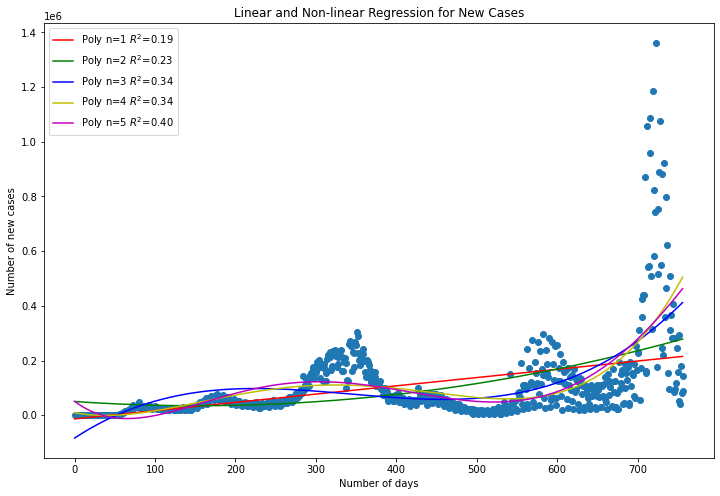

In [347]:
plt. figure(figsize=(12,8))
plt.scatter(us_firstcase_df['num_of_days'],abs(us_firstcase_df['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=1.0)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=1.0)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=1.0)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=1.0)
plt.title("Linear and Non-linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

In [348]:
model_death1, y_pred_d1 = generate_model(1,us_firstdeath_df,"death")
model_death2, y_pred_d2 = generate_model(2,us_firstdeath_df,"death")
model_death3, y_pred_d3 = generate_model(3,us_firstdeath_df,"death")
model_death4, y_pred_d4 = generate_model(4,us_firstdeath_df,"death")
model_death5, y_pred_d5 = generate_model(5,us_firstdeath_df,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  957.6865296227676
RMSE(Root Mean Square Error) value for the Linear model is:  953.3340899474284
RMSE(Root Mean Square Error) value for the Linear model is:  889.1888084351983
RMSE(Root Mean Square Error) value for the Linear model is:  872.2188375498639
RMSE(Root Mean Square Error) value for the Linear model is:  871.8248081254507


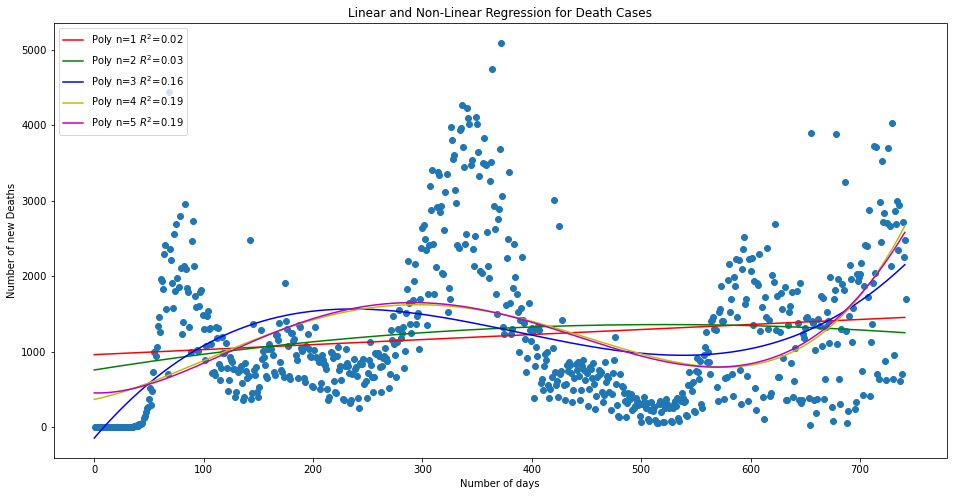

In [349]:
plt. figure(figsize=(16,8))
plt.scatter(us_firstdeath_df['num_of_days'],abs(us_firstdeath_df['new_death']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=1.0)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=1.0)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=1.0)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=1.0)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=1.0)
plt.title("Linear and Non-Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()
plt.show("png")

#### From the rsquared line(red) we generated above is definitely not a Linear model. There is some dependency between number of days and number of new cases. But, it is not linear. This is where Polynomial or non-linear modelling is useful to find a best fit regression line.

### Bias vs Variance tradeoff

For the cases model, the polynomial regression model has more error than the linear regression model therefore using a high bias, low vairance model is better here.

For the deaths model, the polynomial regression model has more error than the linear regression model therefore using a high bias, low vairance model is better here.

## Plot the trend lines for US new cases

Text(0, 0.5, 'New Cases')

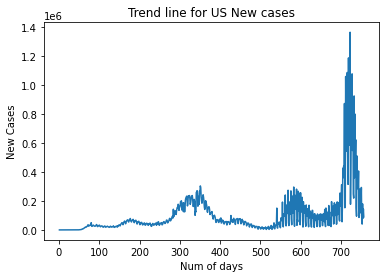

In [227]:
plt.plot(us_firstcase_df['num_of_days'],abs(us_firstcase_df['new_cases']))
plt.title("Trend line for US New cases")
plt.xlabel("Num of days")
plt.ylabel("New Cases")

## Plot the trend lines for US new deaths

Text(0, 0.5, 'New Deaths')

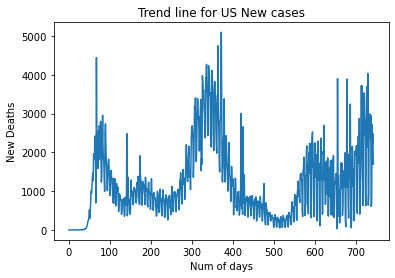

In [228]:
plt.plot(us_firstdeath_df['num_of_days'],abs(us_firstdeath_df['new_death']))
plt.title("Trend line for US New cases")
plt.xlabel("Num of days")
plt.ylabel("New Deaths")

## Plot a trend line for next one week prediction for covid-19 new cases in United States

In [229]:
# calculate the next 7 days input to x-axis and feed it to the model
def calculate_future_days(df):
    future_days = []
    future_days_df = ""
    for days in range((len(df)+1),(len(df)+7)):
        future_days.append(days)
        future_days_df = pd.DataFrame(future_days,columns=['num_of_days']) 
    return future_days_df

In [230]:
future_days_df = calculate_future_days(us_firstcase_df)

In [231]:
predict_newcases_us = model1.predict(future_days_df['num_of_days'])

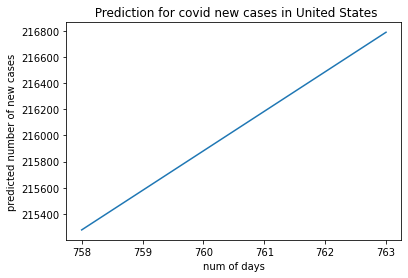

In [232]:
plt.xlabel("num of days")
plt.ylabel("predicted number of new cases")
plt.title(" Prediction for covid new cases in United States")
plt.plot(future_days_df['num_of_days'],predict_newcases_us)

In [233]:
predict_newcases_us_death = model_death1.predict(future_days_df['num_of_days'])

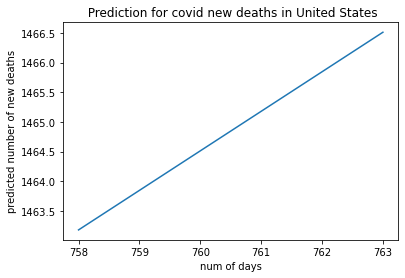

In [234]:
plt.xlabel("num of days")
plt.ylabel("predicted number of new deaths")
plt.title(" Prediction for covid new deaths in United States")
plt.plot(future_days_df['num_of_days'],predict_newcases_us_death)

## Reading other countries data

In [235]:
world_covid = pd.read_csv("../../../data/owid-covid-data.csv")
world_covid

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166784,ZWE,Africa,Zimbabwe,2022-03-03,237503.0,0.0,362.286,5396.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
166785,ZWE,Africa,Zimbabwe,2022-03-04,238739.0,1236.0,467.429,5397.0,1.0,0.714,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
166786,ZWE,Africa,Zimbabwe,2022-03-05,239019.0,280.0,459.429,5397.0,0.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
166787,ZWE,Africa,Zimbabwe,2022-03-06,239209.0,190.0,486.571,5399.0,2.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


## Reading selected other countries data

In [236]:
covid_afg = world_covid[world_covid['location'] == 'Afghanistan']
covid_singa = world_covid[world_covid['location'] == 'Singapore']
covid_port = world_covid[world_covid['location'] == 'Portugal']

In [237]:
covid_afg = covid_afg.reset_index()

c = 0
for i in covid_afg['total_cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1

0


In [238]:
covid_afg['Day_count'] = [x for x in range(1,len(covid_afg)+1)]
covid_afg

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
0,0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,1
1,1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,2
2,2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,3
3,3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,4
4,4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,738,AFG,Asia,Afghanistan,2022-03-03,174214.0,141.0,166.714,7619.0,2.0,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,739
739,739,AFG,Asia,Afghanistan,2022-03-04,174214.0,0.0,161.429,7619.0,0.0,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,740
740,740,AFG,Asia,Afghanistan,2022-03-05,174331.0,117.0,169.286,7622.0,3.0,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,741
741,741,AFG,Asia,Afghanistan,2022-03-06,174582.0,251.0,169.571,7623.0,1.0,...,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,742


In [239]:
covid_singa = covid_singa.reset_index()

c = 0
for i in covid_singa['total_cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1

0


In [240]:
covid_singa['Day_count'] = [x for x in range(1,len(covid_singa)+1)]
covid_singa

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
0,134560,SGP,Asia,Singapore,2020-01-23,1.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,1
1,134561,SGP,Asia,Singapore,2020-01-24,3.0,2.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,2
2,134562,SGP,Asia,Singapore,2020-01-25,3.0,0.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,3
3,134563,SGP,Asia,Singapore,2020-01-26,4.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,4
4,134564,SGP,Asia,Singapore,2020-01-27,5.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,135330,SGP,Asia,Singapore,2022-03-03,785825.0,18162.0,17803.857,1049.0,9.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,771
771,135331,SGP,Asia,Singapore,2022-03-04,803389.0,17564.0,17656.286,1067.0,18.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,772
772,135332,SGP,Asia,Singapore,2022-03-05,819663.0,16274.0,17573.000,1073.0,6.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,773
773,135333,SGP,Asia,Singapore,2022-03-06,832821.0,13158.0,17420.143,1078.0,5.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,774


In [241]:
covid_port = covid_port.reset_index()

c = 0
for i in covid_port['total_cases'].values:
    if i > 0:
        print(c)
        break
    c = c + 1

1


In [242]:
covid_port = covid_port[1:]
covid_port['Day_count'] = [x for x in range(1,len(covid_port)+1)]
covid_port

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
1,121884,PRT,Europe,Portugal,2020-03-02,2.0,2.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,1
2,121885,PRT,Europe,Portugal,2020-03-03,2.0,0.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,2
3,121886,PRT,Europe,Portugal,2020-03-04,5.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,3
4,121887,PRT,Europe,Portugal,2020-03-05,8.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,4
5,121888,PRT,Europe,Portugal,2020-03-06,13.0,5.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,122615,PRT,Europe,Portugal,2022-03-03,3294691.0,12234.0,9088.000,21141.0,30.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,732
733,122616,PRT,Europe,Portugal,2022-03-04,3308438.0,13747.0,9569.571,21162.0,21.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,733
734,122617,PRT,Europe,Portugal,2022-03-05,3322134.0,13696.0,10118.857,21182.0,20.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,734
735,122618,PRT,Europe,Portugal,2022-03-06,3332200.0,10066.0,10541.571,21199.0,17.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,735


In [243]:
covid_afg.shape

(743, 69)

## Afganisthan

In [244]:
# finding whether the data has null values
covid_afg = covid_afg.fillna(0)
covid_afg

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
0,0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,1
1,1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,2
2,2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,3
3,3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,4
4,4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,738,AFG,Asia,Afghanistan,2022-03-03,174214.0,141.0,166.714,7619.0,2.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,739
739,739,AFG,Asia,Afghanistan,2022-03-04,174214.0,0.0,161.429,7619.0,0.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,740
740,740,AFG,Asia,Afghanistan,2022-03-05,174331.0,117.0,169.286,7622.0,3.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,741
741,741,AFG,Asia,Afghanistan,2022-03-06,174582.0,251.0,169.571,7623.0,1.0,...,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0,742


In [245]:

covid_afg['new_cases'].isna().sum()

0

In [246]:
covid_afg['new_deaths'].isna().sum()

0

### Afganisthan cases

In [247]:
#Train Data
x_train = covid_afg['Day_count'][:700]
y_train = covid_afg['new_cases'][:700]

#Test Data
x_test = covid_afg['Day_count'][700:]
y_test = covid_afg['new_cases'][700:]

In [248]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [249]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [250]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[280.67590435],
       [280.82595992],
       [280.97601548],
       [281.12607105],
       [281.27612662],
       [281.42618218],
       [281.57623775],
       [281.72629331],
       [281.87634888],
       [282.02640444],
       [282.17646001],
       [282.32651558],
       [282.47657114],
       [282.62662671],
       [282.77668227],
       [282.92673784],
       [283.0767934 ],
       [283.22684897],
       [283.37690454],
       [283.5269601 ],
       [283.67701567],
       [283.82707123],
       [283.9771268 ],
       [284.12718236],
       [284.27723793],
       [284.4272935 ],
       [284.57734906],
       [284.72740463],
       [284.87746019],
       [285.02751576],
       [285.17757132],
       [285.32762689],
       [285.47768246],
       [285.62773802],
       [285.77779359],
       [285.92784915],
       [286.07790472],
       [286.22796028],
       [286.37801585],
       [286.52807142],
       [286.67812698],
       [286.82818255],
       [286.97823811]])

### RMSE for Afganisthan 

In [251]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

438.2998584959205

In [252]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

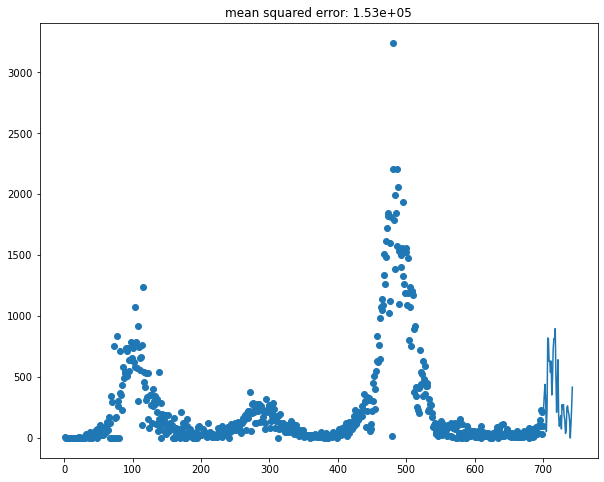

In [253]:
# degreee 2
afg_model = PolynomialRegression(2)
afg_model.fit(x_train, y_train)
afg_p2 = afg_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(afg_model.predict(x_train), y_train)));

In [254]:
MSE = np.square(np.subtract(x_test,afg_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

625.3005393806668

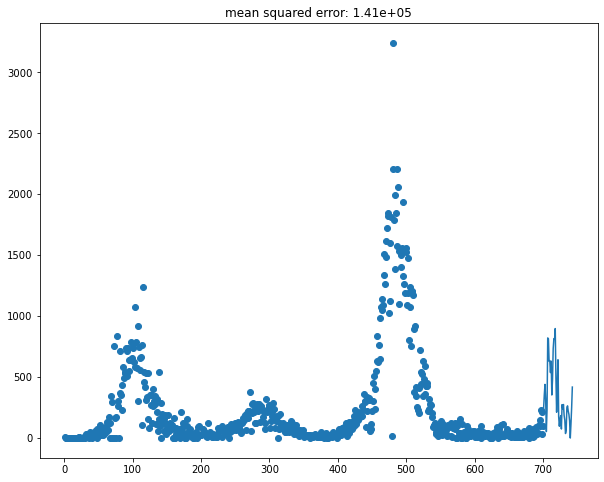

In [255]:
# degreee 3
afg_model = PolynomialRegression(3)
afg_model.fit(x_train, y_train)
afg_p2 = afg_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(afg_model.predict(x_train), y_train)));

In [256]:
MSE = np.square(np.subtract(x_test,afg_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

1035.362064896775

### Afganisthan Deaths

In [257]:
#Train Data
x_train = covid_afg['Day_count'][:700]
y_train = covid_afg['new_deaths'][:700]

#Test Data
x_test = covid_afg['Day_count'][700:]
y_test = covid_afg['new_deaths'][700:]

In [258]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [259]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [260]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[14.80680564],
       [14.81891799],
       [14.83103033],
       [14.84314268],
       [14.85525502],
       [14.86736737],
       [14.87947971],
       [14.89159206],
       [14.9037044 ],
       [14.91581675],
       [14.92792909],
       [14.94004144],
       [14.95215379],
       [14.96426613],
       [14.97637848],
       [14.98849082],
       [15.00060317],
       [15.01271551],
       [15.02482786],
       [15.0369402 ],
       [15.04905255],
       [15.06116489],
       [15.07327724],
       [15.08538959],
       [15.09750193],
       [15.10961428],
       [15.12172662],
       [15.13383897],
       [15.14595131],
       [15.15806366],
       [15.170176  ],
       [15.18228835],
       [15.19440069],
       [15.20651304],
       [15.21862538],
       [15.23073773],
       [15.24285008],
       [15.25496242],
       [15.26707477],
       [15.27918711],
       [15.29129946],
       [15.3034118 ],
       [15.31552415]])

### RMSE for Afganisthan 

In [261]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

707.0451248478395

In [262]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

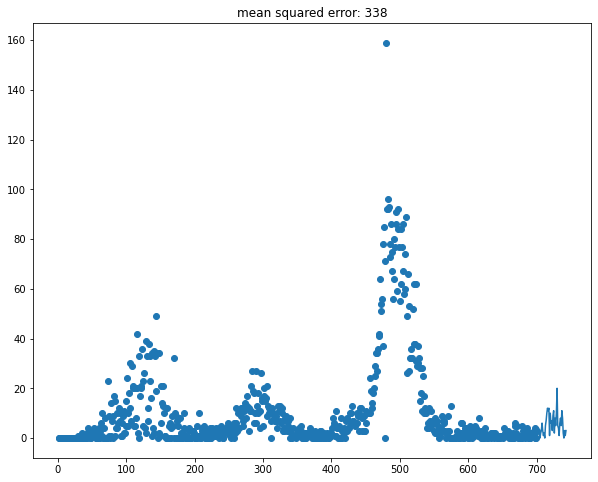

In [263]:
# degreee 2
afg_model = PolynomialRegression(2)
afg_model.fit(x_train, y_train)
afg_p2 = afg_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(afg_model.predict(x_train), y_train)));

### RMSE

In [264]:
MSE = np.square(np.subtract(x_test,afg_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

718.2095703399087

Polynomial degree 3


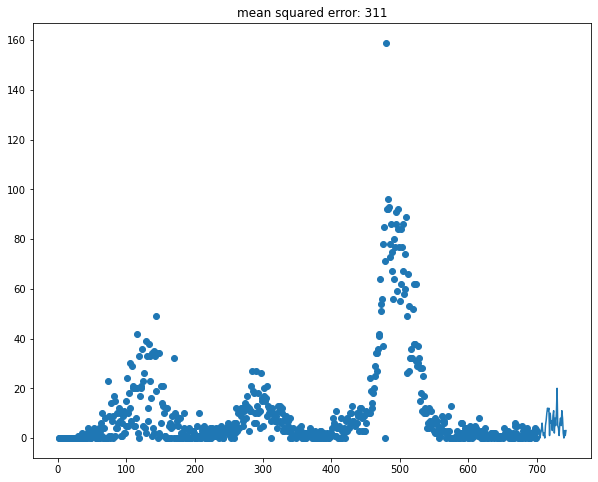

In [265]:
# degreee 3
afg_model = PolynomialRegression(3)
afg_model.fit(x_train, y_train)
afg_p2 = afg_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(afg_model.predict(x_train), y_train)));

### RMSE

In [266]:
MSE = np.square(np.subtract(x_test,afg_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

737.554241682164

In [267]:
covid_singa['Day_count'] = [x for x in range(1,len(covid_singa)+1)]
covid_singa

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
0,134560,SGP,Asia,Singapore,2020-01-23,1.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,1
1,134561,SGP,Asia,Singapore,2020-01-24,3.0,2.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,2
2,134562,SGP,Asia,Singapore,2020-01-25,3.0,0.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,3
3,134563,SGP,Asia,Singapore,2020-01-26,4.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,4
4,134564,SGP,Asia,Singapore,2020-01-27,5.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,135330,SGP,Asia,Singapore,2022-03-03,785825.0,18162.0,17803.857,1049.0,9.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,771
771,135331,SGP,Asia,Singapore,2022-03-04,803389.0,17564.0,17656.286,1067.0,18.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,772
772,135332,SGP,Asia,Singapore,2022-03-05,819663.0,16274.0,17573.000,1073.0,6.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,773
773,135333,SGP,Asia,Singapore,2022-03-06,832821.0,13158.0,17420.143,1078.0,5.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,774


In [268]:
covid_singa['Day_count'] = [x for x in range(1,len(covid_singa)+1)]
covid_singa

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
0,134560,SGP,Asia,Singapore,2020-01-23,1.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,1
1,134561,SGP,Asia,Singapore,2020-01-24,3.0,2.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,2
2,134562,SGP,Asia,Singapore,2020-01-25,3.0,0.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,3
3,134563,SGP,Asia,Singapore,2020-01-26,4.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,4
4,134564,SGP,Asia,Singapore,2020-01-27,5.0,1.0,NaN,NaN,NaN,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,135330,SGP,Asia,Singapore,2022-03-03,785825.0,18162.0,17803.857,1049.0,9.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,771
771,135331,SGP,Asia,Singapore,2022-03-04,803389.0,17564.0,17656.286,1067.0,18.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,772
772,135332,SGP,Asia,Singapore,2022-03-05,819663.0,16274.0,17573.000,1073.0,6.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,773
773,135333,SGP,Asia,Singapore,2022-03-06,832821.0,13158.0,17420.143,1078.0,5.0,...,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN,774


In [270]:
covid_singa.shape

(775, 69)

In [271]:
y_train

array([[  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  1.],
       [  0.],
       [  0.],
       [  1.],
       [  0.],
       [  0.],
       [  2.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  1.],
       [  0.],
       [  2.],
       [  0.],
       [  4.],
       [  3.],
       [  1.],
       [  0.],
       [  0.],
       [  3.],
       [  1.],
       [  3.],
       [  3.],
       [  4.],
       [  1.],
       [  0.],
       [  0.],
       [  3.],
       [  3.],
       [  0.],
       [  4.],
       [  0.],
       [  3.],
       [  6.],
       [  1.],
       [ 10.],
       [  0.],
       [  

## singapore


In [272]:
# finding whether the data has null values
covid_singa = covid_singa.fillna(0)
covid_singa

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
0,134560,SGP,Asia,Singapore,2020-01-23,1.0,1.0,0.000,0.0,0.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,1
1,134561,SGP,Asia,Singapore,2020-01-24,3.0,2.0,0.000,0.0,0.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,2
2,134562,SGP,Asia,Singapore,2020-01-25,3.0,0.0,0.000,0.0,0.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,3
3,134563,SGP,Asia,Singapore,2020-01-26,4.0,1.0,0.000,0.0,0.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,4
4,134564,SGP,Asia,Singapore,2020-01-27,5.0,1.0,0.000,0.0,0.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,135330,SGP,Asia,Singapore,2022-03-03,785825.0,18162.0,17803.857,1049.0,9.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,771
771,135331,SGP,Asia,Singapore,2022-03-04,803389.0,17564.0,17656.286,1067.0,18.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,772
772,135332,SGP,Asia,Singapore,2022-03-05,819663.0,16274.0,17573.000,1073.0,6.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,773
773,135333,SGP,Asia,Singapore,2022-03-06,832821.0,13158.0,17420.143,1078.0,5.0,...,28.3,0.0,2.4,83.62,0.938,0.0,0.0,0.0,0.0,774


In [273]:

covid_singa['new_cases'].isna().sum()

0

In [274]:
covid_singa['new_deaths'].isna().sum()

0

### Singapore cases

In [275]:
#Train Data
x_train = covid_singa['Day_count'][:700]
y_train = covid_singa['new_cases'][:700]

#Test Data
x_test = covid_singa['Day_count'][700:]
y_test = covid_singa['new_cases'][700:]

In [276]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [277]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [278]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[1002.54042918],
       [1004.27288608],
       [1006.00534298],
       [1007.73779988],
       [1009.47025678],
       [1011.20271368],
       [1012.93517058],
       [1014.66762748],
       [1016.40008439],
       [1018.13254129],
       [1019.86499819],
       [1021.59745509],
       [1023.32991199],
       [1025.06236889],
       [1026.79482579],
       [1028.52728269],
       [1030.25973959],
       [1031.99219649],
       [1033.72465339],
       [1035.45711029],
       [1037.18956719],
       [1038.92202409],
       [1040.65448099],
       [1042.38693789],
       [1044.11939479],
       [1045.85185169],
       [1047.58430859],
       [1049.31676549],
       [1051.04922239],
       [1052.78167929],
       [1054.51413619],
       [1056.24659309],
       [1057.97904999],
       [1059.71150689],
       [1061.44396379],
       [1063.17642069],
       [1064.90887759],
       [1066.64133449],
       [1068.37379139],
       [1070.10624829],
       [1071.83870519],
       [1073.571

### RMSE for Singaore 

In [279]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

329.0236513853554

In [280]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

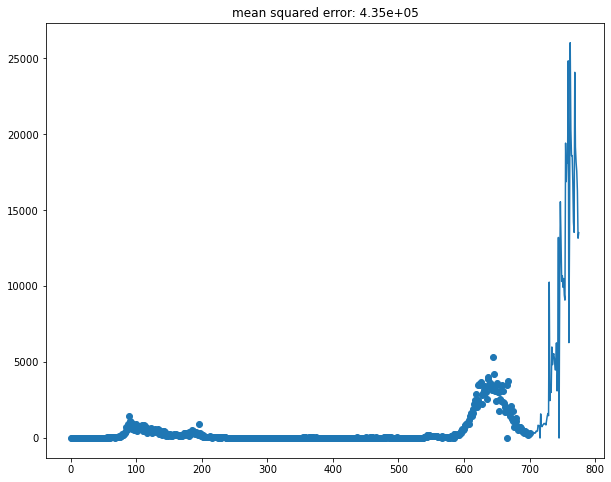

In [281]:
# degreee 2
singa_model = PolynomialRegression(2)
singa_model.fit(x_train, y_train)
singa_p2 = singa_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(singa_model.predict(x_train), y_train)));

### RMSE

In [282]:
MSE = np.square(np.subtract(x_test,singa_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

1488.1304866438088

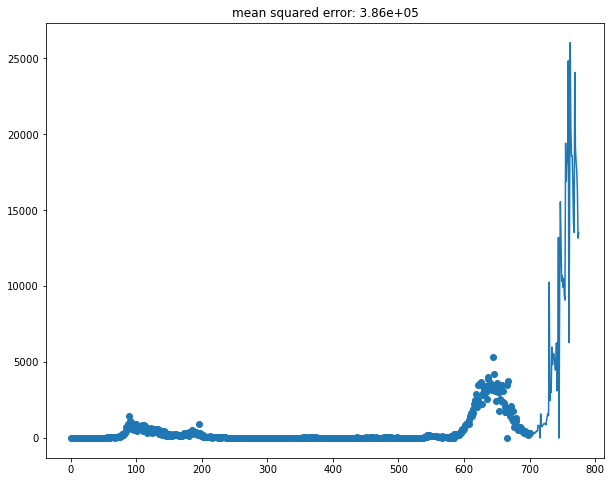

In [283]:
# degreee 3
singa_model = PolynomialRegression(3)
singa_model.fit(x_train, y_train)
singa_p2 = singa_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(singa_model.predict(x_train), y_train)));

### RMSE

In [284]:
MSE = np.square(np.subtract(x_test,singa_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

2542.5424270844555

## Singapore Deaths

In [285]:
#Train Data
x_train = covid_singa['Day_count'][:700]
y_train = covid_singa['new_deaths'][:700]

#Test Data
x_test = covid_singa['Day_count'][700:]
y_test = covid_singa['new_deaths'][700:]

In [286]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [287]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [288]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[3.96166769],
       [3.96963658],
       [3.97760547],
       [3.98557436],
       [3.99354325],
       [4.00151214],
       [4.00948103],
       [4.01744992],
       [4.02541882],
       [4.03338771],
       [4.0413566 ],
       [4.04932549],
       [4.05729438],
       [4.06526327],
       [4.07323216],
       [4.08120105],
       [4.08916994],
       [4.09713883],
       [4.10510772],
       [4.11307662],
       [4.12104551],
       [4.1290144 ],
       [4.13698329],
       [4.14495218],
       [4.15292107],
       [4.16088996],
       [4.16885885],
       [4.17682774],
       [4.18479663],
       [4.19276552],
       [4.20073442],
       [4.20870331],
       [4.2166722 ],
       [4.22464109],
       [4.23260998],
       [4.24057887],
       [4.24854776],
       [4.25651665],
       [4.26448554],
       [4.27245443],
       [4.28042332],
       [4.28839222],
       [4.29636111],
       [4.30433   ],
       [4.31229889],
       [4.32026778],
       [4.32823667],
       [4.336

### RMSE for singapore

In [289]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

734.0577131788862

In [290]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

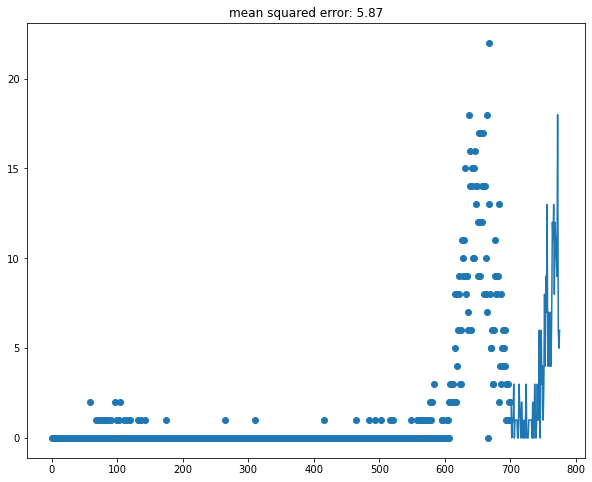

In [291]:
# degreee 2
singa_model = PolynomialRegression(2)
singa_model.fit(x_train, y_train)
singa_p2 = singa_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(singa_model.predict(x_train), y_train)));

### RMSE

In [292]:
MSE = np.square(np.subtract(x_test,singa_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

729.4712529229365

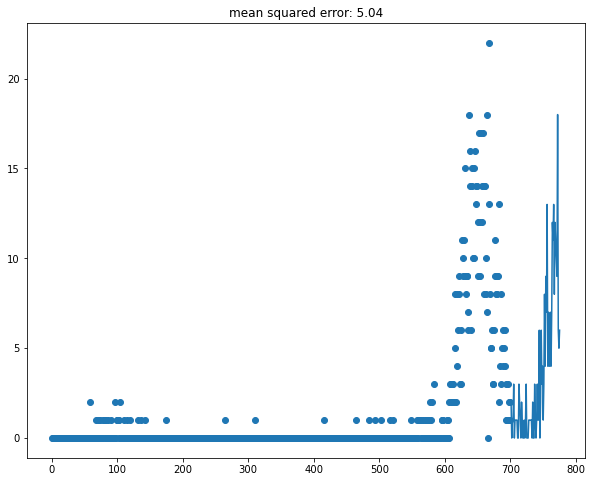

In [293]:
# degreee 3
singa_model = PolynomialRegression(3)
singa_model.fit(x_train, y_train)
singa_p2 = singa_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(singa_model.predict(x_train), y_train)));

### RMSE

In [294]:
MSE = np.square(np.subtract(x_test,singa_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

725.1874404664067

## Portugal

In [295]:
covid_port['Day_count'] = [x for x in range(1,len(covid_port)+1)]
covid_port

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
2,121885,PRT,Europe,Portugal,2020-03-03,2.0,0.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,1
3,121886,PRT,Europe,Portugal,2020-03-04,5.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,2
4,121887,PRT,Europe,Portugal,2020-03-05,8.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,3
5,121888,PRT,Europe,Portugal,2020-03-06,13.0,5.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,4
6,121889,PRT,Europe,Portugal,2020-03-07,20.0,7.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,122615,PRT,Europe,Portugal,2022-03-03,3294691.0,12234.0,9088.000,21141.0,30.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,731
733,122616,PRT,Europe,Portugal,2022-03-04,3308438.0,13747.0,9569.571,21162.0,21.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,732
734,122617,PRT,Europe,Portugal,2022-03-05,3322134.0,13696.0,10118.857,21182.0,20.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,733
735,122618,PRT,Europe,Portugal,2022-03-06,3332200.0,10066.0,10541.571,21199.0,17.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,734


In [296]:
covid_port['Day_count'] = [x for x in range(1,len(covid_port)+1)]
covid_port

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
2,121885,PRT,Europe,Portugal,2020-03-03,2.0,0.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,1
3,121886,PRT,Europe,Portugal,2020-03-04,5.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,2
4,121887,PRT,Europe,Portugal,2020-03-05,8.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,3
5,121888,PRT,Europe,Portugal,2020-03-06,13.0,5.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,4
6,121889,PRT,Europe,Portugal,2020-03-07,20.0,7.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,122615,PRT,Europe,Portugal,2022-03-03,3294691.0,12234.0,9088.000,21141.0,30.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,731
733,122616,PRT,Europe,Portugal,2022-03-04,3308438.0,13747.0,9569.571,21162.0,21.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,732
734,122617,PRT,Europe,Portugal,2022-03-05,3322134.0,13696.0,10118.857,21182.0,20.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,733
735,122618,PRT,Europe,Portugal,2022-03-06,3332200.0,10066.0,10541.571,21199.0,17.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,734


In [297]:
covid_port = covid_port[1:]
covid_port['Day_count'] = [x for x in range(1,len(covid_port)+1)]
covid_port

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
3,121886,PRT,Europe,Portugal,2020-03-04,5.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,1
4,121887,PRT,Europe,Portugal,2020-03-05,8.0,3.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,2
5,121888,PRT,Europe,Portugal,2020-03-06,13.0,5.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,3
6,121889,PRT,Europe,Portugal,2020-03-07,20.0,7.0,NaN,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,4
7,121890,PRT,Europe,Portugal,2020-03-08,30.0,10.0,4.286,NaN,NaN,...,30.0,NaN,3.39,82.05,0.864,-2150.6,-7.94,-8.7,-211.508289,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,122615,PRT,Europe,Portugal,2022-03-03,3294691.0,12234.0,9088.000,21141.0,30.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,730
733,122616,PRT,Europe,Portugal,2022-03-04,3308438.0,13747.0,9569.571,21162.0,21.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,731
734,122617,PRT,Europe,Portugal,2022-03-05,3322134.0,13696.0,10118.857,21182.0,20.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,732
735,122618,PRT,Europe,Portugal,2022-03-06,3332200.0,10066.0,10541.571,21199.0,17.0,...,30.0,NaN,3.39,82.05,0.864,NaN,NaN,NaN,NaN,733


In [298]:
covid_port.shape

(734, 69)

In [299]:
y_train

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
      

## Portuguese

In [300]:
# finding whether the data has null values
covid_port = covid_port.fillna(0)
covid_port

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Day_count
3,121886,PRT,Europe,Portugal,2020-03-04,5.0,3.0,0.000,0.0,0.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,1
4,121887,PRT,Europe,Portugal,2020-03-05,8.0,3.0,0.000,0.0,0.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,2
5,121888,PRT,Europe,Portugal,2020-03-06,13.0,5.0,0.000,0.0,0.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,3
6,121889,PRT,Europe,Portugal,2020-03-07,20.0,7.0,0.000,0.0,0.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,4
7,121890,PRT,Europe,Portugal,2020-03-08,30.0,10.0,4.286,0.0,0.0,...,30.0,0.0,3.39,82.05,0.864,-2150.6,-7.94,-8.7,-211.508289,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,122615,PRT,Europe,Portugal,2022-03-03,3294691.0,12234.0,9088.000,21141.0,30.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,730
733,122616,PRT,Europe,Portugal,2022-03-04,3308438.0,13747.0,9569.571,21162.0,21.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,731
734,122617,PRT,Europe,Portugal,2022-03-05,3322134.0,13696.0,10118.857,21182.0,20.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,732
735,122618,PRT,Europe,Portugal,2022-03-06,3332200.0,10066.0,10541.571,21199.0,17.0,...,30.0,0.0,3.39,82.05,0.864,0.0,0.00,0.0,0.000000,733


In [301]:

covid_port['new_cases'].isna().sum()

0

In [302]:
covid_port['new_deaths'].isna().sum()

0

### Portuguese cases

In [303]:
#Train Data
x_train = covid_port['Day_count'][:700]
y_train = covid_port['new_cases'][:700]

#Test Data
x_test = covid_port['Day_count'][700:]
y_test = covid_port['new_cases'][700:]

In [304]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [305]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [306]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[10150.50560392],
       [10168.49828753],
       [10186.49097114],
       [10204.48365474],
       [10222.47633835],
       [10240.46902195],
       [10258.46170556],
       [10276.45438917],
       [10294.44707277],
       [10312.43975638],
       [10330.43243998],
       [10348.42512359],
       [10366.4178072 ],
       [10384.4104908 ],
       [10402.40317441],
       [10420.39585801],
       [10438.38854162],
       [10456.38122523],
       [10474.37390883],
       [10492.36659244],
       [10510.35927605],
       [10528.35195965],
       [10546.34464326],
       [10564.33732686],
       [10582.33001047],
       [10600.32269408],
       [10618.31537768],
       [10636.30806129],
       [10654.30074489],
       [10672.2934285 ],
       [10690.28611211],
       [10708.27879571],
       [10726.27147932],
       [10744.26416292]])

### RMSE for portuguese 

In [307]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

9731.31297189311

In [308]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

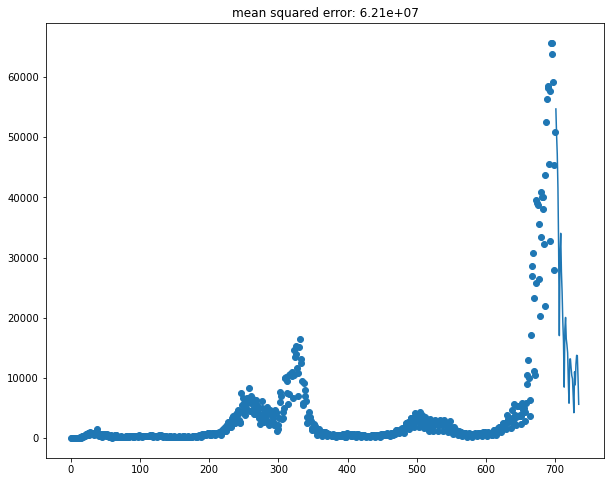

In [309]:
# degreee 2
port_model = PolynomialRegression(2)
port_model.fit(x_train, y_train)
port_p2 = port_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(port_model.predict(x_train), y_train)));

### RMSE

In [310]:
MSE = np.square(np.subtract(x_test,port_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

17803.987515610548

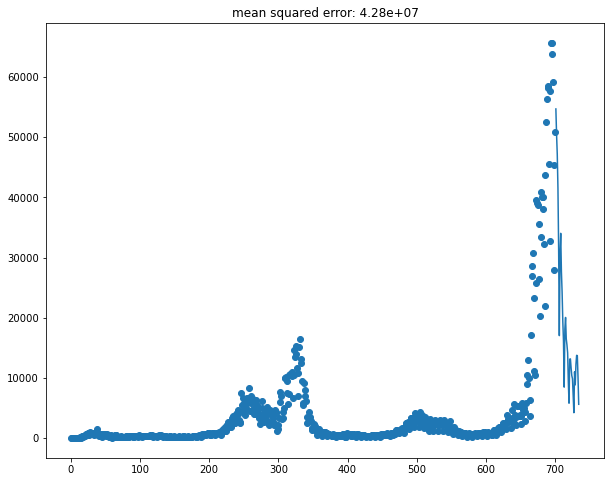

In [311]:
# degreee 3
port_model = PolynomialRegression(3)
port_model.fit(x_train, y_train)
port_p2 = port_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(port_model.predict(x_train), y_train)));

### RMSE

In [312]:
MSE = np.square(np.subtract(x_test,port_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

33215.11656682358

### Portuguese Deaths

In [313]:
#Train Data
x_train = covid_port['Day_count'][:700]
y_train = covid_port['new_deaths'][:700]

#Test Data
x_test = covid_port['Day_count'][700:]
y_test = covid_port['new_deaths'][700:]

In [314]:
# Reshaping the Data
x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)

x_test = np.array(x_test).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [315]:
#Linear Regression
linr = LinearRegression()
linr.fit(x_train,y_train)

LinearRegression()

In [316]:
linr_predicted = linr.predict(x_test)
linr_predicted

array([[24.76219497],
       [24.7514574 ],
       [24.74071983],
       [24.72998225],
       [24.71924468],
       [24.70850711],
       [24.69776953],
       [24.68703196],
       [24.67629439],
       [24.66555682],
       [24.65481924],
       [24.64408167],
       [24.6333441 ],
       [24.62260652],
       [24.61186895],
       [24.60113138],
       [24.59039381],
       [24.57965623],
       [24.56891866],
       [24.55818109],
       [24.54744351],
       [24.53670594],
       [24.52596837],
       [24.51523079],
       [24.50449322],
       [24.49375565],
       [24.48301808],
       [24.4722805 ],
       [24.46154293],
       [24.45080536],
       [24.44006778],
       [24.42933021],
       [24.41859264],
       [24.40785507]])

### RMSE for portuguese

In [317]:
MSE = np.square(np.subtract(x_test,linr_predicted)).mean() 
RMSE = math.sqrt(MSE)
RMSE

692.985923834602

In [318]:
def PolynomialRegression(degree, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

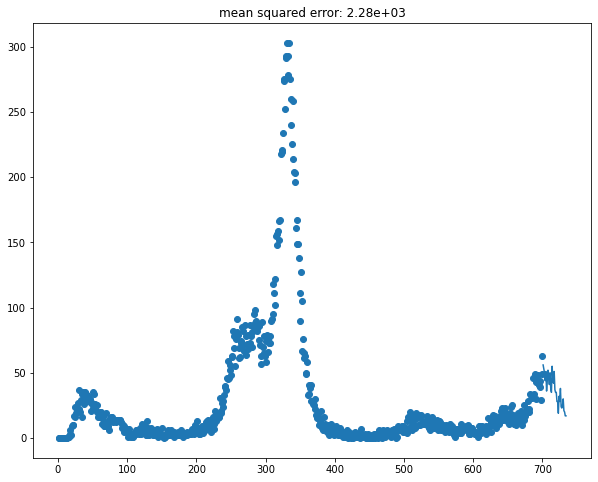

In [319]:
# degreee 2
port_model = PolynomialRegression(2)
port_model.fit(x_train, y_train)
port_p2 = port_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(port_model.predict(x_train), y_train)));

### RMSE

In [320]:
MSE = np.square(np.subtract(x_test,port_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

733.2049708673956

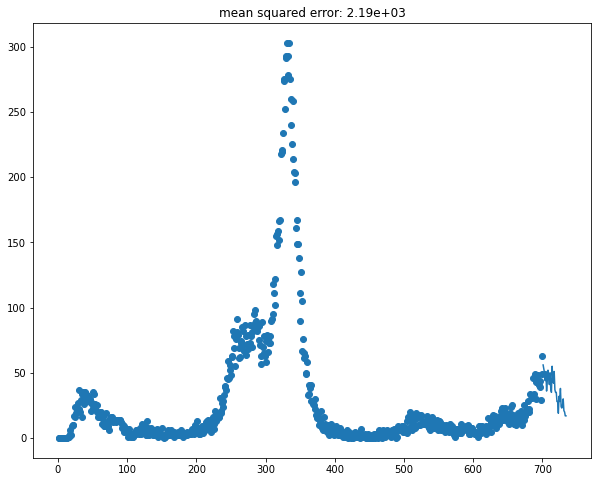

In [321]:
# degreee 3
port_model = PolynomialRegression(3)
port_model.fit(x_train, y_train)
port_p2 = port_model.predict(x_test)

#Plotting the MSE
plt.figure(figsize=(10,8))
plt.scatter(x_train.ravel(), y_train)
plt.plot(x_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(port_model.predict(x_train), y_train)));

### RMSE

In [322]:
MSE = np.square(np.subtract(x_test,port_model.predict(x_test))).mean() 
RMSE = math.sqrt(MSE)
RMSE

700.7155874115265

### Best model Prediction of USA was Linear Regression

In [323]:
px.line(y_pred1)

In [324]:
covid_df = pd.read_parquet("../../../data/covid_combined_dataset.parquet.gzip")
covid_df.head()

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
0,1001,Autauga County,AL,1,2020-01-22,0,0,55869
1,1001,Autauga County,AL,1,2020-01-23,0,0,55869
2,1001,Autauga County,AL,1,2020-01-24,0,0,55869
3,1001,Autauga County,AL,1,2020-01-25,0,0,55869
4,1001,Autauga County,AL,1,2020-01-26,0,0,55869


In [325]:
covid_df1 = covid_df.groupby('Date')[['Cases','Death']].sum()

In [326]:
covid_df1 = covid_df1.reset_index()
covid_df1

,Date,Cases,Death
0,2020-01-22,723,1
1,2020-01-23,734,1
2,2020-01-24,741,1
3,2020-01-25,751,1
4,2020-01-26,759,1
...,...,...,...
753,2022-02-13,75409177,874847
754,2022-02-14,75585682,877542
755,2022-02-15,75665834,879789
756,2022-02-16,75808328,882239


### 7 Day rolling average

In [327]:
covid_df1['7day_cases_rolling_avg'] = covid_df1['Cases'].rolling( 7).mean()
covid_df1['7day_deaths_rolling_avg'] = covid_df1['Death'].rolling( 7).mean()
covid_df1

,Date,Cases,Death,7day_cases_rolling_avg,7day_deaths_rolling_avg
0,2020-01-22,723,1,NaN,NaN
1,2020-01-23,734,1,NaN,NaN
2,2020-01-24,741,1,NaN,NaN
3,2020-01-25,751,1,NaN,NaN
4,2020-01-26,759,1,NaN,NaN
...,...,...,...,...,...
753,2022-02-13,75409177,874847,7.501799e+07,869901.714286
754,2022-02-14,75585682,877542,7.517206e+07,872036.857143
755,2022-02-15,75665834,879789,7.532082e+07,874108.428571
756,2022-02-16,75808328,882239,7.545474e+07,876104.428571


### Plotly cases of 7 day rolling average

In [328]:
px.line(covid_df1, x='Date', y=['7day_cases_rolling_avg','7day_deaths_rolling_avg'])


In [329]:
covid_df.head()

,countyFIPS,County Name,State,StateFIPS,Date,Cases,Death,population
0,1001,Autauga County,AL,1,2020-01-22,0,0,55869
1,1001,Autauga County,AL,1,2020-01-23,0,0,55869
2,1001,Autauga County,AL,1,2020-01-24,0,0,55869
3,1001,Autauga County,AL,1,2020-01-25,0,0,55869
4,1001,Autauga County,AL,1,2020-01-26,0,0,55869


## Normalizing according to Mean

In [330]:
# total cases and deaths for every county
covid_df2 = covid_df.groupby(['County Name', 'countyFIPS'])[['Cases','Death']].sum()
covid_df2 = covid_df2.reset_index()
covid_df2

,County Name,countyFIPS,Cases,Death
0,Abbeville County,45001,1427054,20217
1,Acadia Parish,22001,4136761,108305
2,Accomack County,51001,1715953,27219
3,Ada County,16001,29720355,274327
4,Adair County,19001,437982,14483
...,...,...,...,...
3137,Yuma County,4027,19276788,417033
3138,Yuma County,8125,474828,7625
3139,Zapata County,48505,889035,17621
3140,Zavala County,48507,978904,22520


In [331]:
# mean cases and deaths for every county

covid_df3 = covid_df.groupby(['County Name', 'countyFIPS'])[['Cases','Death']].mean()
covid_df3 = covid_df3.reset_index()
covid_df3

,County Name,countyFIPS,Cases,Death
0,Abbeville County,45001,1882.656992,26.671504
1,Acadia Parish,22001,5457.468338,142.882586
2,Accomack County,51001,2263.790237,35.908971
3,Ada County,16001,39208.911609,361.908971
4,Adair County,19001,577.812665,19.106860
...,...,...,...,...
3137,Yuma County,4027,25431.118734,550.175462
3138,Yuma County,8125,626.422164,10.059367
3139,Zapata County,48505,1172.869393,23.246702
3140,Zavala County,48507,1291.430079,29.709763


In [332]:
covid_df3['norm_cases'] = (covid_df2['Cases'] / covid_df3['Cases'])
covid_df3['norm_deaths'] = (covid_df2['Death'] / covid_df3['Death'])


In [333]:
covid_df3

,County Name,countyFIPS,Cases,Death,norm_cases,norm_deaths
0,Abbeville County,45001,1882.656992,26.671504,758.0,758.0
1,Acadia Parish,22001,5457.468338,142.882586,758.0,758.0
2,Accomack County,51001,2263.790237,35.908971,758.0,758.0
3,Ada County,16001,39208.911609,361.908971,758.0,758.0
4,Adair County,19001,577.812665,19.106860,758.0,758.0
...,...,...,...,...,...,...
3137,Yuma County,4027,25431.118734,550.175462,758.0,758.0
3138,Yuma County,8125,626.422164,10.059367,758.0,758.0
3139,Zapata County,48505,1172.869393,23.246702,758.0,758.0
3140,Zavala County,48507,1291.430079,29.709763,758.0,758.0


### The normalised values are so less that they can't be visualized in choropleth map. So, we are plotting the county level cases and deaths.

### Choropleth Map for Cases

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import plotly.express as px

fig = px.choropleth(covid_df3, geojson=counties, locations='countyFIPS', color='Cases',
                           color_continuous_scale="Viridis",
                           range_color=(1000, 50000),
                           scope="usa",
                           labels={'cases':'county_cases'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Choropleth Map for Deaths

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import plotly.express as px

fig = px.choropleth(covid_df3, geojson=counties, locations='countyFIPS', color='Death',
                           color_continuous_scale="Viridis",
                           range_color=(1, 200),
                           scope="usa",
                           labels={'norm_deaths':'norm_deaths'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()